In [1]:

import warnings
import time
import os
import pandas as pd
import glob
import itertools
import requests
import numpy as np
from scipy import linalg
# import matplotlib.pyplot as plt
# import matplotlib as mpl
from sklearn import mixture
warnings.filterwarnings("ignore")
from json import JSONEncoder
import datetime
import json
import matplotlib as mpl
import matplotlib.pyplot as plt


class NumpyArrayEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return JSONEncoder.default(self, obj)

class DateTimeEncoder(JSONEncoder):
        #Override the default method
        def default(self, obj):
            if isinstance(obj, (datetime.date, datetime.datetime)):
                return obj.isoformat()


def plot_results(X, Y_, means, covariances, index, title):
    # Creating subplots
    plt.figure(figsize=(20,20))
    splot = plt.subplot(2, 1, 1 + index)
    # Plot the points and ellipse
    color_iter = itertools.cycle(['navy', 'c', 'cornflowerblue', 'gold',
                                  'darkorange'])
    for i, (mean, covar, color) in enumerate(zip(
            means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], 8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], angle, color=color)
        #print(mean, v[0], v[1], angle)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)
        
    # Define the plot properties 
    # plt.xlim(-30, 2000)
    # plt.ylim(-5, 250)
    # plt.xticks(np.arange(-30, 2000, 100))
    # plt.yticks(np.arange(-5, 250, 5))
    plt.title(title)
    plt.show()

def get_data(id,attri,start_date , end_date):
    ''' 
    Edit this if your running a cron Job 
    queryTimeDiff = datetime.timedelta(minutes=90)
    endDate = datetime.datetime.now()
    startDate = datetime.datetime.now() - queryTimeDiff
    '''
    [id1 , id2] = id.split(",")
    [attri1 , attri2] = attri.split(",")

    #Change the start data and End Data for longer duration 
    query = {'id':id1,'attributes':attri1,'startDate':start_date,'endDate':end_date}
    # id1+att1 ; id2+att2
    # merge
    query = DateTimeEncoder().encode(query)
    query = eval(query)
    response = requests.get('http://54.206.42.58:8006/api/v2/historicalData/getObjectAttributeHistoricalData', params=query)
    data1 = response.json()
    exportedData1 = data1["data"]["ObjectData"]
    df1 = pd.DataFrame(exportedData1)
    

    #Change the start data and End Data for longer duration 
    query2 = {'id':id2,'attributes':attri2,'startDate':start_date,'endDate':end_date}  
    # id1+att1 ; id2+att2
    # merge
    query2 = DateTimeEncoder().encode(query2)
    query2 = eval(query2)
    response2 = requests.get('http://54.206.42.58:8006/api/v2/historicalData/getObjectAttributeHistoricalData', params=query2)
    data2 = response2.json()
    exportedData2 = data2["data"]["ObjectData"]
    df2 = pd.DataFrame(exportedData2)
    #print(df2.head(5))

 
    df = pd.concat([df1, df2])


    #print(df.head(5))
    pivoted = df.pivot( index= 'measurementtimestamp' , columns='attributeserviceid' , values= 'value' )
    pivoted = pivoted[[attri1,attri2]]
    pivoted = pivoted.dropna(how='any',axis=0) 
    return pivoted
    # #print( pivoted.columns)
    # xaxis, yaxis =  pivoted.columns
    # #print(pivoted.head(5))
    # return pivoted.to_numpy() , xaxis, yaxis


# Function to PRODUCE the results
# def att_ellipse(means, covariances, index, title, nclusters):
#     ell_centers = [None]*nclusters
#     ell_axislengths = [None]*nclusters
#     ell_angles = [None]*nclusters
#     # Find the attributes of the ellipse
#     for i, (mean, covar) in enumerate(zip(
#             means, covariances)):
#         v, w = linalg.eigh(covar)
#         v = 2. * np.sqrt(2.) * np.sqrt(v)
#         u = w[0] / linalg.norm(w[0])

#         # Produce an ellipse to show the Gaussian component
#         angle = np.arctan(u[1] / u[0])
#         angle = 180. * angle / np.pi  # convert to degrees
        
#         ##print(mean, v[0], v[1], 180. + angle)
#         ell_centers[i] = [i, mean[0], mean[1]]
#         ell_axislengths[i] = [i, v[0], v[1]]
#         ell_angles[i] = [i,  angle]
#     return ell_centers, ell_axislengths, ell_angles


# def boot( id, attri,  start_date, end_date  , number_of_clusters):    
    
#     X  , xaxis, yaxis = get_data(id, attri,  start_date, end_date)
#     print(X)
#     cluster_numbers = number_of_clusters;
#     dpgmm = mixture.BayesianGaussianMixture(n_components=cluster_numbers,
#                                             covariance_type='full',random_state=12).fit(X)
#     XY_VALUES = X
#     CLUSTERID = dpgmm.predict(X)

#     ELL_CENTERS, ELL_AXISLENGTHS, ELL_ANGLES = att_ellipse(dpgmm.means_, dpgmm.covariances_, 1,
#                 'Bayesian Gaussian Mixture clustering', cluster_numbers)
#     #print(ELL_CENTERS)
#     #print(ELL_AXISLENGTHS)
#     #print(ELL_ANGLES)
#     lists = []
#     xy_value_data = XY_VALUES.astype(float)
#     # xy_value_data = xy_value_data.tolist()
#     for i,y in zip(xy_value_data,CLUSTERID):
#         d_ = { 'value':list(i) , 'name':str(y) }
#         lists.append(d_)
#     print(CLUSTERID)
#     plot_results(X, CLUSTERID, dpgmm.means_, dpgmm.covariances_, 1,'Bayesian Gaussian Mixture clustering')

#     plt.show()
  
#     #return {'ELL_CENTERS': ELL_CENTERS , 'ELL_AXISLENGTHS' : ELL_AXISLENGTHS , 'ELL_ANGLES' : ELL_ANGLES , 'XY_VALUES': lists}
  
# #boot( 'WP_SF_MVPS4.WS1,WP_SF_MVPS4.PM1', 'Irradiance Global (W/m^2),Active Power', '2021-10-01 00:00:00' , '2021-11-01 00:00:00' , 4 )

# #boot( 'WP_SF_MVPS4.PM1,WP_SF_MVPS4.WS1', 'Active Power,Irradiance Global (W/m^2)', '2021-10-01 00:00:00' , '2021-11-01 00:00:00' , 4 )

# #boot( 'WP_SF_MVPS4.WS1,WP_SF_MVPS4.PM1', 'Back-of-Module Temperature 2 (deg C),Active Power', '2021-10-01 00:00:00' , '2021-11-01 00:00:00' , 4 )

# #boot( 'WP_SF_MVPS4.WS1,WP_SF_MVPS4.PM1', 'AVG in-plane irradiance,Active Power', '2021-10-01 00:00:00' , '2021-11-01 00:00:00' , 4 )


# #boot( 'WP_SF_MVPS4.WS1,WP_SF_MVPS4.PM1', 'Irradiance Global (W/m^2),Active Power', '2021-10-01 00:00:00' , '2021-11-01 00:00:00' , 4 )
# boot( 'WP_SF_MVPS4.WS1,WP_SF_MVPS4.WS1', 'Ambient Temperature Celsius,Weather Atmospheric Pressure', '2021-11-01 00:00:00' , '2021-11-30 00:00:00' , 4 )





In [7]:
get_data( 'WP_SF_MVPS4.WS1,WP_SF_MVPS4.WS1', 'Ambient Temperature Celsius,Weather Atmospheric Pressure', '2021-11-01 00:00:00' , '2021-11-30 00:00:00'  )


attributeserviceid,Ambient Temperature Celsius,Weather Atmospheric Pressure
measurementtimestamp,,
2021-11-01T00:00:00.000Z,17.100000381469727,1014
2021-11-01T00:05:00.000Z,16.899999618530273,1014
2021-11-01T00:10:00.000Z,16.899999618530273,1014
2021-11-01T00:15:00.000Z,17,1014
2021-11-01T00:20:00.000Z,17,1014
...,...,...
2021-11-23T14:35:00.000Z,15.899999618530273,1003
2021-11-23T14:40:00.000Z,16,1003
2021-11-23T14:45:00.000Z,15.899999618530273,1003


## This code gets two attributes hittin the db once 

###  Getting Data 

In [49]:
def get_data(id,attri,start_date , end_date, period = 'D'):
    ''' 
    Edit this if your running a cron Job 
    queryTimeDiff = datetime.timedelta(minutes=90)
    endDate = datetime.datetime.now()
    startDate = datetime.datetime.now() - queryTimeDiff
    '''
    [id1 , id2] = id.split(",")
    [attri1 , attri2] = attri.split(",")

    #Change the start data and End Data for longer duration 
    query = {'id':id,'attributes':attri,'startDate':start_date,'endDate':end_date}
    
    query = DateTimeEncoder().encode(query)
    query = eval(query)
    
    response = requests.get('http://54.206.42.58:8006/api/v2/historicalData/getObjectAttributeHistoricalData', params=query)
           
    data1 = response.json()
    exportedData1 = data1["data"]["ObjectData"]
    df = pd.DataFrame(exportedData1)


    pivoted = df.pivot( index= 'measurementtimestamp' , columns='attributeserviceid' , values= 'value' )
    pivoted = pivoted[[attri1,attri2]]
    pivoted = pivoted.dropna(how='any',axis=0) 
    if( period  == '1H' ):
        pivoted =  resample_to_hour(pivoted)
    elif(period == 'D'): 
        pivoted =  resample_to_day(pivoted)
    elif(period == 'M'):
        pivoted =  resample_to_Month(pivoted)
    xaxis, yaxis =  pivoted.columns
    return pivoted.to_numpy() , xaxis, yaxis  

def resample_to_hour( df ):
      temp = df.astype('float')    
  temp = temp.reset_index()
  temp['measurementtimestamp']  = pd.to_datetime(temp['measurementtimestamp'],utc=True)
  temp = temp.resample('1H', on='measurementtimestamp').mean().dropna(how='any',axis=0) 
  return temp 

def resample_to_day( df ):
  temp = df.astype('float')    
  temp = temp.reset_index()
  temp['measurementtimestamp']  = pd.to_datetime(temp['measurementtimestamp'],utc=True)
  temp = temp.resample('D', on='measurementtimestamp').mean().dropna(how='any',axis=0) 
  return temp 

def resample_to_Month( df ):
  temp = df.astype('float')    
  temp = temp.reset_index()
  temp['measurementtimestamp']  = pd.to_datetime(temp['measurementtimestamp'],utc=True)
  temp = temp.resample('M', on='measurementtimestamp').dropna(how='any',axis=0) 
  return temp 

### Calling the function 

In [50]:
df,xaxis, yaxis  = get_data( 'WP_SF_MVPS4.WS1,WP_SF_MVPS4.WS1', 'Ambient Temperature Celsius,Weather Atmospheric Pressure', '2021-11-01 00:00:00' , '2021-11-30 00:00:00' , period = 'D'  )

In [51]:
df

array([[  14.3835165 , 1012.32600733],
       [  23.99338235, 1005.44117647],
       [  14.8359259 , 1010.29259259],
       [  14.51734318, 1013.61623616],
       [  17.01722847, 1002.25468165],
       [  16.9672598 ,  996.50177936],
       [  12.27601477, 1000.31365314],
       [  12.61343873, 1002.15019763],
       [  14.27360595, 1000.57992565],
       [  10.6275362 ,  999.03985507],
       [  12.75655432,  992.82397004],
       [  12.00786519,  991.58052434],
       [   9.47326005,  995.11355311],
       [   9.61557972,  993.19927536],
       [   9.42234846, 1003.88636364],
       [  10.69027779, 1011.21759259],
       [  12.96831683, 1005.73267327],
       [  17.60335819,  997.94029851],
       [  13.08231047, 1003.76895307],
       [  12.66605839, 1007.22262774],
       [  14.01775362, 1011.27898551],
       [  16.08469754, 1007.26690391],
       [  22.89127907, 1003.10465116]])

In [35]:
r = resample_to_day( df )

In [38]:
r.index

DatetimeIndex(['2021-11-01 00:00:00+00:00', '2021-11-02 00:00:00+00:00',
               '2021-11-03 00:00:00+00:00', '2021-11-04 00:00:00+00:00',
               '2021-11-05 00:00:00+00:00', '2021-11-06 00:00:00+00:00',
               '2021-11-07 00:00:00+00:00', '2021-11-08 00:00:00+00:00',
               '2021-11-09 00:00:00+00:00', '2021-11-10 00:00:00+00:00',
               '2021-11-11 00:00:00+00:00', '2021-11-12 00:00:00+00:00',
               '2021-11-13 00:00:00+00:00', '2021-11-14 00:00:00+00:00',
               '2021-11-15 00:00:00+00:00', '2021-11-16 00:00:00+00:00',
               '2021-11-17 00:00:00+00:00', '2021-11-18 00:00:00+00:00',
               '2021-11-19 00:00:00+00:00', '2021-11-20 00:00:00+00:00',
               '2021-11-21 00:00:00+00:00', '2021-11-22 00:00:00+00:00',
               '2021-11-23 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='measurementtimestamp', freq='D')

## New code functional 

[[  17.27499994 1013.75      ]
 [  17.76666657 1013.        ]
 [  17.87000008 1013.        ]
 ...
 [  16.82499997 1004.08333333]
 [  16.05000019 1004.        ]
 [  15.92499971 1003.5       ]]
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 3 3 3 3 3 3 3 3 3 3 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 3

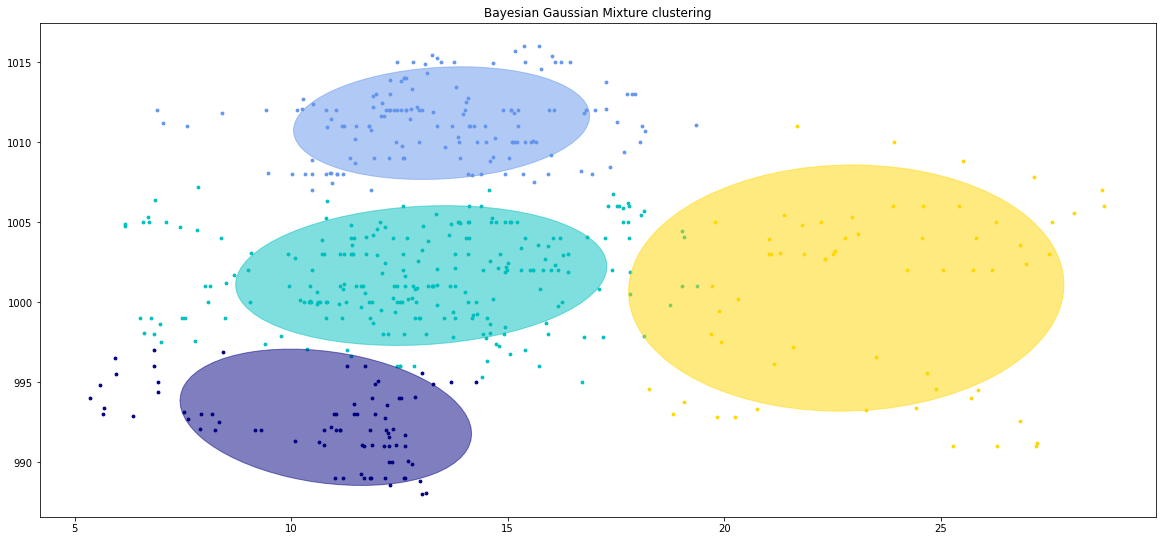

In [60]:

import warnings
import time
import os
import pandas as pd
import glob
import itertools
import requests
import numpy as np
from scipy import linalg
# import matplotlib.pyplot as plt
# import matplotlib as mpl
from sklearn import mixture
warnings.filterwarnings("ignore")
from json import JSONEncoder
import datetime
import json
import matplotlib as mpl
import matplotlib.pyplot as plt


class NumpyArrayEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return JSONEncoder.default(self, obj)

class DateTimeEncoder(JSONEncoder):
        #Override the default method
        def default(self, obj):
            if isinstance(obj, (datetime.date, datetime.datetime)):
                return obj.isoformat()


def plot_results(X, Y_, means, covariances, index, title):
    # Creating subplots
    plt.figure(figsize=(20,20))
    splot = plt.subplot(2, 1, 1 + index)
    # Plot the points and ellipse
    color_iter = itertools.cycle(['navy', 'c', 'cornflowerblue', 'gold',
                                  'darkorange'])
    for i, (mean, covar, color) in enumerate(zip(
            means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], 8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], angle, color=color)
        #print(mean, v[0], v[1], angle)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)
        
    # Define the plot properties 
    # plt.xlim(-30, 2000)
    # plt.ylim(-5, 250)
    # plt.xticks(np.arange(-30, 2000, 100))
    # plt.yticks(np.arange(-5, 250, 5))
    plt.title(title)
    plt.show()

def get_data(id,attri,start_date , end_date, period = 'D'):
    ''' 
    Edit this if your running a cron Job 
    queryTimeDiff = datetime.timedelta(minutes=90)
    endDate = datetime.datetime.now()
    startDate = datetime.datetime.now() - queryTimeDiff
    '''
    [id1 , id2] = id.split(",")
    [attri1 , attri2] = attri.split(",")

    #Change the start data and End Data for longer duration 
    query = {'id':id,'attributes':attri,'startDate':start_date,'endDate':end_date}
    
    query = DateTimeEncoder().encode(query)
    query = eval(query)
    
    response = requests.get('http://54.206.42.58:8006/api/v2/historicalData/getObjectAttributeHistoricalData', params=query)
           
    data1 = response.json()
    exportedData1 = data1["data"]["ObjectData"]
    df = pd.DataFrame(exportedData1)


    pivoted = df.pivot( index= 'measurementtimestamp' , columns='attributeserviceid' , values= 'value' )
    pivoted = pivoted[[attri1,attri2]]
    pivoted = pivoted.dropna(how='any',axis=0) 
    if( period  == '1H' ):
        pivoted =  resample_to_hour(pivoted).dropna(how='any',axis=0) 
    elif(period == 'D'): 
        pivoted =  resample_to_day(pivoted).dropna(how='any',axis=0) 
    elif(period == 'M'):
        pivoted =  resample_to_Month(pivoted).dropna(how='any',axis=0) 
    xaxis, yaxis =  pivoted.columns
    return pivoted.to_numpy() , xaxis, yaxis  

def resample_to_hour( df ):
  temp = df.astype('float')    
  temp = temp.reset_index()
  temp['measurementtimestamp']  = pd.to_datetime(temp['measurementtimestamp'],utc=True)
  temp = temp.resample('1H', on='measurementtimestamp').mean()
  return temp 

def resample_to_day( df ):
  temp = df.astype('float')    
  temp = temp.reset_index()
  temp['measurementtimestamp']  = pd.to_datetime(temp['measurementtimestamp'],utc=True)
  temp = temp.resample('D', on='measurementtimestamp').mean()
  return temp 

def resample_to_Month( df ):
  temp = df.astype('float')    
  temp = temp.reset_index()
  temp['measurementtimestamp']  = pd.to_datetime(temp['measurementtimestamp'],utc=True)
  temp = temp.resample('M', on='measurementtimestamp')
  return temp 

#Function to PRODUCE the results
def att_ellipse(means, covariances, index, title, nclusters):
    ell_centers = [None]*nclusters
    ell_axislengths = [None]*nclusters
    ell_angles = [None]*nclusters
    # Find the attributes of the ellipse
    for i, (mean, covar) in enumerate(zip(
            means, covariances)):
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])

        # Produce an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        
        ##print(mean, v[0], v[1], 180. + angle)
        ell_centers[i] = [i, mean[0], mean[1]]
        ell_axislengths[i] = [i, v[0], v[1]]
        ell_angles[i] = [i,  angle]
    return ell_centers, ell_axislengths, ell_angles


def boot( id, attri,  start_date, end_date  , number_of_clusters,period = 'raw'):    
    
    X  , xaxis, yaxis = get_data(id, attri,  start_date, end_date,period)
    print(X)
    cluster_numbers = number_of_clusters;
    dpgmm = mixture.BayesianGaussianMixture(n_components=cluster_numbers,
                                            covariance_type='full',random_state=12).fit(X)
    XY_VALUES = X
    CLUSTERID = dpgmm.predict(X)

    ELL_CENTERS, ELL_AXISLENGTHS, ELL_ANGLES = att_ellipse(dpgmm.means_, dpgmm.covariances_, 1,
                'Bayesian Gaussian Mixture clustering', cluster_numbers)
    #print(ELL_CENTERS)
    #print(ELL_AXISLENGTHS)
    #print(ELL_ANGLES)
    lists = []
    xy_value_data = XY_VALUES.astype(float)
    #xy_value_data = xy_value_data.tolist()
    for i,y in zip(xy_value_data,CLUSTERID):
        d_ = { 'value':list(i) , 'name':str(y) }
        lists.append(d_)
    print(CLUSTERID)
    plot_results(X, CLUSTERID, dpgmm.means_, dpgmm.covariances_, 1,'Bayesian Gaussian Mixture clustering')

    plt.show()
  
    #return {'ELL_CENTERS': ELL_CENTERS , 'ELL_AXISLENGTHS' : ELL_AXISLENGTHS , 'ELL_ANGLES' : ELL_ANGLES , 'XY_VALUES': lists}
  
#boot( 'WP_SF_MVPS4.WS1,WP_SF_MVPS4.PM1', 'Irradiance Global (W/m^2),Active Power', '2021-10-01 00:00:00' , '2021-11-01 00:00:00' , 4 )
#boot( 'WP_SF_MVPS4.PM1,WP_SF_MVPS4.WS1', 'Active Power,Irradiance Global (W/m^2)', '2021-10-01 00:00:00' , '2021-11-01 00:00:00' , 4 )
#boot( 'WP_SF_MVPS4.WS1,WP_SF_MVPS4.PM1', 'Back-of-Module Temperature 2 (deg C),Active Power', '2021-10-01 00:00:00' , '2021-11-01 00:00:00' , 4 )
#boot( 'WP_SF_MVPS4.WS1,WP_SF_MVPS4.PM1', 'AVG in-plane irradiance,Active Power', '2021-10-01 00:00:00' , '2021-11-01 00:00:00' , 4 )
#boot( 'WP_SF_MVPS4.WS1,WP_SF_MVPS4.PM1', 'Irradiance Global (W/m^2),Active Power', '2021-10-01 00:00:00' , '2021-11-01 00:00:00' , 4 )

boot( 'WP_SF_MVPS4.WS1,WP_SF_MVPS4.WS1', 'Ambient Temperature Celsius,Weather Atmospheric Pressure', '2021-11-01 00:00:00' , '2021-11-30 00:00:00' , 4 , period = '1H')



